# AI 201 Programming Assignment 2
## Naive Bayes Spam Filter Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [1]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# from collections import Counter
# from scipy.sparse import csr_matrix
# from scipy.sparse import vstack
from tqdm import tqdm

In [2]:
# Notebook Constants

PATH_TO_TREC06 = "trec06p-ai201/"

In [3]:
def read_labels(base_path):
    # Path to the labels file
    labels_path = os.path.join(base_path, "labels")

    labels_dict = {}
    with open(labels_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                label, file_path = parts
                file_path = file_path[3:] # Don't include ".." which is a prefix in the labels file
                labels_dict[file_path] = label
                
    return labels_dict

def read_documents(base_path, labels_dict):
    X = []  # List to store document contents
    Y = []  # List to store labels
    
    # Root directory for documents
    data_dir = os.path.join(base_path, "data")

    # Iterate through all subdirectories
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            for file in os.listdir(subdir_path):
                file_path = os.path.join(subdir_path, file)
                relative_path = os.path.relpath(file_path, base_path)
                if relative_path in labels_dict:
                    # print(f"Reading from {relative_path}")
                    with open(file_path, "r", errors="ignore") as f:
                        content = f.read()
                        
                    # Tokenization
                    words = re.findall(r"\b[a-zA-Z]+\b", content.lower())
                    
                    X.append(words)
                    Y.append(1 if labels_dict[relative_path] == "spam" else 0)
                    
    return X, Y

def read_trec06_corpus(base_path):
    # Get labels
    labels_dict = read_labels(base_path)
                
    # Get features
    X, Y = read_documents(base_path, labels_dict)

    return X, Y

## Store features in X and labels in Y

In [4]:
X, Y = read_trec06_corpus(PATH_TO_TREC06)

print(f"Total documents processed: {len(X)}")
print(f"Number of spam: {sum(Y)}")
print(f"Number of ham: {len(Y) - sum(Y)}")

Total documents processed: 37822
Number of spam: 24912
Number of ham: 12910


In [5]:
print(f"X[:2] = {X[:2]}")
print(f"Y[:2] = {Y[:2]}")

X[:2] = [['received', 'from', 'mail', 'bqdr', 'com', 'unknown', 'by', 'augustus', 'cs', 'umn', 'edu', 'postfix', 'with', 'esmtp', 'id', 'for', 'harper', 'cs', 'umn', 'edu', 'sat', 'jul', 'cdt', 'received', 'qmail', 'invoked', 'by', 'uid', 'sat', 'jul', 'date', 'sat', 'jul', 'message', 'id', 'qmail', 'mail', 'bqdr', 'com', 'mime', 'version', 'content', 'type', 'text', 'plain', 'charset', 'iso', 'jp', 'content', 'transfer', 'encoding', 'from', 'iso', 'jp', 'b', 'sousin', 'bqdr', 'com', 'to', 'harper', 'cs', 'umn', 'edu', 'subject', 'b', 'h', 'a', 'k', 'q', 'h', 'b', 'hf', 'w', 'i', 'j', 'k', 'h', 'a', 'k', 'fo', 'f', 'k', 'h', 'r', 'cn', 'i', 'jv', 'v', 'r', 'f', 'j', 'a', 'n', 'w', 'ievj', 'kld', 'o', 'f', 'c', 'f', 'j', 'b', 'http', 'www', 'vcxl', 'com', 'num', 'b', 'aj', 'j', 'o', 'i', 'j', 'n', 's', 'w', 'n', 'a', 'c', 'r', 'f', 'k', 'j', 'i', 'j', 'h', 'k', 'g', 'jaa', 'a', 'c', 'r', 'b', 'b', 's', 'b', 'nds', 'o', 'bk', 'a', 'h', 'n', 'v', 'g', 'b', 'j', 'b', 'p', 'b', 'i', 'a', 'f

## Split the dataset into train and test sets

The function below is reminiscent to the `train_test_split()` function of sklearn, which takes in the following parameters:
- features X
- labels y
- test_size in decimal
- random_state which sets the seed to randomization of the order of the data

In [6]:
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    
    # Create list of indices and shuffle it
    indices = list(range(len(X)))
    random.shuffle(indices)
    
    # Calculate split point
    split = int(len(X) * (1 - test_size))
    
    # Split the data
    train_indices = indices[:split]
    test_indices = indices[split:]
    
    X_train = [X[i] for i in train_indices]
    X_test = [X[i] for i in test_indices]
    y_train = [y[i] for i in train_indices]
    y_test = [y[i] for i in test_indices]
    
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Dataset size: {len(X_train) + len(X_test)}")

Training set size: 26475
Test set size: 11347
Dataset size: 37822


## Build the vocabulary

In [8]:
from collections import Counter

# Create a vocabulary from the training data
def create_vocabulary(X_train):
    vocabulary = set()
    for document in X_train:
        vocabulary.update(document)
    return list(vocabulary)

In [9]:
V = create_vocabulary(X_train)
vocab_size = len(V)

In [10]:
# print(f"V = {V}")
print(f"vocab_size = {vocab_size}")

vocab_size = 204140


In [11]:
def compute_prior_probabilities(y_train):
    total_docs = len(y_train)
    class_counts = Counter(y_train)
    priors = {cls: count / total_docs for cls, count in class_counts.items()}
    return priors

In [12]:
priors = compute_prior_probabilities(y_train)

print(f"Prior probabilities: {priors}")

Prior probabilities: {0: 0.34115203021718604, 1: 0.658847969782814}


## Naive Bayes Classifier

In [13]:
class NaiveBayesClassifier:
    def __init__(self, smoothing_factor=1):
        self.smoothing_factor = smoothing_factor  # Laplace smoothing parameter
        self.vocabulary = None
        self.vocab_size = None
        self.word_to_index = None
        self.priors = None
        self.likelihoods = None
        self.label_word_counts = None
        self.labels = None

    def fit(self, X_train, y_train):
        self.create_vocabulary(X_train)

        # Compute prior probabilities
        self.compute_prior_probabilities(y_train)

        # Compute class conditional likelihoods with lambda smoothing
        self.compute_likelihoods(X_train, y_train)

    def create_vocabulary(self, X_train):
        vocabulary_set = set()
        for document in X_train:
            vocabulary_set.update(document)
        self.vocabulary = list(vocabulary_set)
        self.vocab_size = len(self.vocabulary)
        # Map words to indices for faster lookup
        self.word_to_index = {word: idx for idx, word in enumerate(self.vocabulary)}

    def compute_prior_probabilities(self, y_train):
        total_docs = len(y_train)
        label_counts = Counter(y_train)
        self.labels = list(label_counts.keys())
        self.priors = {label: label_counts[label] / total_docs for label in self.labels}

    def compute_likelihoods(self, X_train, y_train):
        # Initialize word counts and total word counts per label/class
        word_counts = {label: np.zeros(self.vocab_size) for label in self.labels}
        self.label_word_counts = {label: 0 for label in self.labels}

        # Count word occurrences per class
        for words, label in zip(X_train, y_train):
            for word in words:
                if word in self.word_to_index:
                    idx = self.word_to_index[word]
                    word_counts[label][idx] += 1
                    self.label_word_counts[label] += 1

        # Compute smoothed likelihoods and convert to log probabilities
        self.likelihoods = {}
        for label in self.labels:
            numerator = word_counts[label] + self.smoothing_factor
            denominator = self.label_word_counts[label] + (self.vocab_size * self.smoothing_factor)
            likelihood = numerator / denominator
            self.likelihoods[label] = np.log(likelihood)  # Convert to log likelihoods

    def predict(self, X_test):
        Y_pred = []
        log_priors = {label: np.log(self.priors[label]) for label in self.labels}

        for document in X_test:
            
            label_scores = {}
            for label in self.labels:
                log_prob = log_priors[label]
                for word in document:
                    if word in self.word_to_index:
                        idx = self.word_to_index[word]
                        log_prob += self.likelihoods[label][idx]
                    else:
                        # Word not in vocabulary; apply lambda smoothing
                        total_words_for_label = self.label_word_counts[label]
                        denominator = total_words_for_label + (self.vocab_size * self.smoothing_factor)
                        smoothed_prob = np.log(self.smoothing_factor) - np.log(denominator)
                        log_prob += smoothed_prob
                label_scores[label] = log_prob
            # Select the label with the highest log probability
            predicted_label = max(label_scores, key=label_scores.get)
            Y_pred.append(predicted_label)
            
        return Y_pred


In [14]:
nbc = NaiveBayesClassifier(smoothing_factor=1)

# Train the classifier
nbc.fit(X_train, y_train)

# Predict the labels for the test set
Y_pred = nbc.predict(X_test)

## Get the precision and recall of the model

In [15]:
def compute_metrics(y_true, y_pred):
    true_positive = sum((y_t == 1 and y_p == 1) for y_t, y_p in zip(y_true, y_pred))
    false_positive = sum((y_t == 0 and y_p == 1) for y_t, y_p in zip(y_true, y_pred))
    false_negative = sum((y_t == 1 and y_p == 0) for y_t, y_p in zip(y_true, y_pred))
    
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        
    return {
        "precision": precision,
        "recall": recall,
    }

In [16]:
metrics = compute_metrics(y_test, y_pred)
print(f"Precision: {metrics['precision']}")
print(f"Recall: {metrics['recall']}")

NameError: name 'y_test' is not defined

## Evaluate classifier for varying smoothing factors

In [18]:
lambda_values = [5e-3, 0.1, 0.5, 1, 2]
precision_results = []
recall_results = []

for lambda_value in tqdm(lambda_values, desc="Training Naive Bayes Classifier for Varying Smoothing Factor"):
    # Create and train a Naive Bayes Classifier for each smoothing factor
    nbc = NaiveBayesClassifier(smoothing_factor=lambda_value)
    
    # Recreate the generator for each iteration
    nbc.fit(X_train, y_train)
    
    # Recreate the generator for prediction
    Y_pred = nbc.predict(X_test)
    
    metrics = compute_metrics(y_test, Y_pred)

    precision_results.append(metrics["precision"])
    recall_results.append(metrics["recall"])

Training Naive Bayes Classifier for Varying Smoothing Factor: 100%|██████████| 5/5 [03:01<00:00, 36.31s/it]


In [19]:
print(f"precision_results = {precision_results}")
print(f"recall_results = {recall_results}")

precision_results = [0.6744701348747592, 0.6744051632790675, 0.6743402041995762, 0.6744051632790675, 0.6744051632790675]
recall_results = [0.9290074309978769, 0.9290074309978769, 0.9290074309978769, 0.9290074309978769, 0.9290074309978769]


## Plot the performance of the classifier for varying smoothing factors

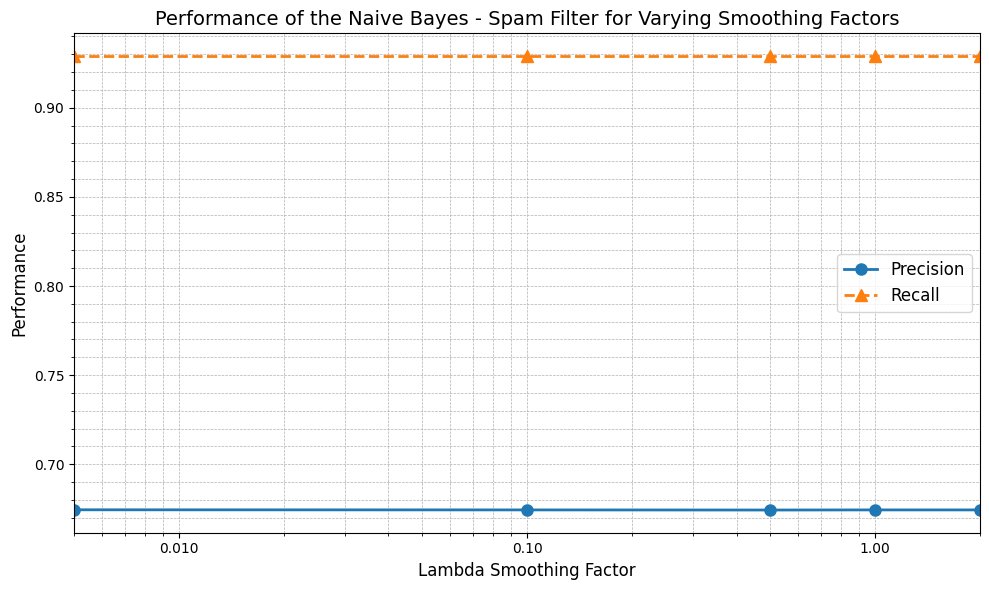

In [20]:
plt.figure(figsize=(10, 6))  # Set the figure size

plt.plot(lambda_values, precision_results, label="Precision", linestyle="-", marker="o", linewidth=2, markersize=8)
plt.plot(lambda_values, recall_results, label="Recall", linestyle="--", marker="^", linewidth=2, markersize=8)

plt.title("Performance of the Naive Bayes - Spam Filter for Varying Smoothing Factors", fontsize=14)
plt.xlabel("Lambda Smoothing Factor", fontsize=12)
plt.ylabel("Performance", fontsize=12)

plt.xscale("log")  # Logarithmic scale for x-axis

# Format x-ticks in decimal notation
def decimal_formatter(x, pos):
    return f"{x:.3f}" if x < 0.1 else f"{x:.2f}"
plt.gca().xaxis.set_major_formatter(FuncFormatter(decimal_formatter))

plt.xlim(min(lambda_values), max(lambda_values))  # Adjust x-axis limits

plt.grid(which='both', linestyle='--', linewidth=0.5)  # Adding grid
plt.minorticks_on()  # Enable minor ticks

plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()